In [1]:
# import necessary libraries
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import math
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV

/Users/Menglong/anaconda3/envs/py37/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [45]:
df=pd.read_table('daily_sale_140100.txt',sep=',')
df.describe()

,Unnamed: 0,shelf_id,product_id,date,weeknum,quantity,sale_price,inventory,past_average,past_max,...,second_type5,second_type6,second_type7,万柏林区,小店区,尖草坪区,晋源区,杏花岭区,清徐县,迎泽区
count,3.495660e+06,3.495660e+06,3.495660e+06,3.495660e+06,3.495660e+06,3.495660e+06,3.495660e+06,3.495660e+06,3.495660e+06,3.495660e+06,...,3.495660e+06,3.495660e+06,3.495660e+06,3.495660e+06,3.495660e+06,3.495660e+06,3.495660e+06,3.495660e+06,3.495660e+06,3.495660e+06
mean,1.747830e+06,2.471539e+04,3.339673e+02,6.200000e+01,9.430894e+00,7.026484e-02,3.840029e+00,2.547055e+00,1.214322e-01,4.405786e-01,...,2.871217e-02,4.503871e-01,4.401830e-02,1.129838e-01,5.245602e-01,6.372273e-02,2.280084e-02,1.221323e-01,1.442646e-03,1.523575e-01
std,1.009110e+06,1.127645e+04,3.207662e+02,3.550587e+01,5.079981e+00,4.971129e-01,2.031270e+00,4.059242e+00,7.247466e-01,1.333519e+00,...,1.669964e-01,4.975325e-01,2.051358e-01,3.165731e-01,4.993965e-01,2.442584e-01,1.492681e-01,3.274386e-01,3.795478e-02,3.593671e-01
min,0.000000e+00,3.785000e+03,3.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,2.950000e-01,-2.200000e+01,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.739148e+05,1.669000e+04,5.300000e+01,3.100000e+01,5.000000e+00,0.000000e+00,2.490000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.747830e+06,2.598200e+04,1.940000e+02,6.200000e+01,9.000000e+00,0.000000e+00,3.800000e+00,1.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.621744e+06,3.484000e+04,6.580000e+02,9.300000e+01,1.400000e+01,0.000000e+00,4.590000e+00,4.000000e+00,7.142857e-02,1.000000e+00,...,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,3.495659e+06,4.031000e+04,1.399000e+03,1.230000e+02,1.800000e+01,2.710000e+02,1.499000e+01,3.160000e+02,1.430000e+02,2.710000e+02,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [46]:
df.drop(['Unnamed: 0'], axis=1,
        inplace=True)  # this column is useless, we drop it
df.columns

Index(['shelf_id', 'product_id', 'date', 'weeknum', 'quantity', 'sale_price',
       'inventory', 'past_average', 'past_max', 'past_var',
       'last_weekday_sale', 'type1', 'type2', 'type3', 'type4', 'type5',
       'second_type1', 'second_type2', 'second_type4', 'second_type5',
       'second_type6', 'second_type7', '万柏林区', '小店区', '尖草坪区', '晋源区', '杏花岭区',
       '清徐县', '迎泽区'],
      dtype='object')

In [47]:
df_plot = df.groupby(['shelf_id', 'product_id']).quantity.agg(['mean', 'std'])
df_plot.describe()

,mean,std
count,28421.000000,28421.000000
mean,0.070263,0.306125
std,0.138870,0.368766
min,0.000000,0.000000
25%,0.016260,0.126992
50%,0.032520,0.216290
75%,0.073171,0.360668
max,5.455285,24.388007


In [48]:
# delete the shelf product pair with 0 mean
df_withoutmean0=df.groupby(['shelf_id', 'product_id']).filter(lambda x: x['quantity'].mean() > 0)
df_plot2=df_withoutmean0.groupby(['shelf_id', 'product_id']).quantity.agg(['mean', 'std'])
df_plot2.describe()

,mean,std
count,28367.000000,28367.000000
mean,0.070396,0.306708
std,0.138968,0.368875
min,0.008130,0.090167
25%,0.016260,0.126992
50%,0.032520,0.219349
75%,0.073171,0.360668
max,5.455285,24.388007


/Users/Menglong/anaconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


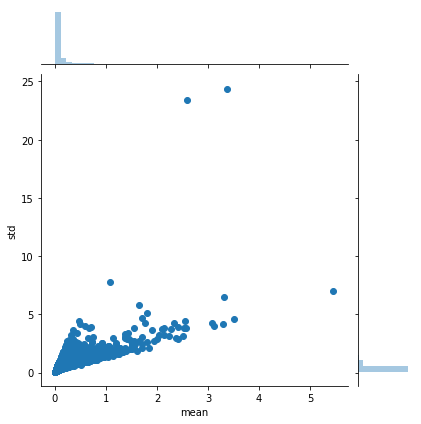

In [49]:
sns.jointplot(x='mean', y='std', data=df_plot2)
plt.show()

In [50]:
# compute the CV of each pair
df_withoutmean0.groupby(['shelf_id','product_id']).quantity\
    .apply(lambda x:x.std()/x.mean()).describe()

count    28367.000000
mean         6.957168
std          2.786948
min          1.150552
25%          4.716285
50%          6.350423
75%          8.746252
max         11.090537
Name: quantity, dtype: float64

In [51]:
df=df_withoutmean0.copy()

In [52]:
# add the two features
df['pairADIclass'] = df['quantity']
df['pairCVclass'] = df['quantity']
cvcutoff1 = 1.2
cvcutoff2 = 4
meancutoff1 = 0.015
meancutoff2 = 0.01
df_ADIclass=df[['shelf_id','product_id','pairADIclass']].groupby(['shelf_id','product_id']).transform(lambda x: x-x+1 if\
    x.mean()>meancutoff1 else(x-x+2 if x.mean()>meancutoff2 else x-x+3))
df_CVclass=df[['shelf_id','product_id','pairCVclass']].groupby(['shelf_id','product_id']).transform(lambda x: x-x+1 if\
    x.std()/x.mean()<cvcutoff1 else(x-x+2 if x.std()/x.mean()<cvcutoff2 else x-x+3))
df['pairADIclass'] = df_ADIclass
df['pairCVclass'] = df_CVclass

In [53]:
df1 = pd.get_dummies(
    df,
    prefix=['ADIclass', 'CVclass'],
    columns=['pairADIclass', 'pairCVclass'])
df1.columns

Index(['shelf_id', 'product_id', 'date', 'weeknum', 'quantity', 'sale_price',
       'inventory', 'past_average', 'past_max', 'past_var',
       'last_weekday_sale', 'type1', 'type2', 'type3', 'type4', 'type5',
       'second_type1', 'second_type2', 'second_type4', 'second_type5',
       'second_type6', 'second_type7', '万柏林区', '小店区', '尖草坪区', '晋源区', '杏花岭区',
       '清徐县', '迎泽区', 'ADIclass_1.0', 'ADIclass_3.0', 'CVclass_1.0',
       'CVclass_2.0', 'CVclass_3.0'],
      dtype='object')

In [55]:
df1[['date','weeknum']].head(90)

,date,weeknum
0,14.0,3.0
1,15.0,3.0
2,16.0,3.0
3,17.0,3.0
4,18.0,3.0
5,19.0,3.0
6,20.0,3.0
7,21.0,4.0
8,22.0,4.0
9,23.0,4.0


In [56]:
# weekly forecast and error with the new dataset
mean_mse = []
mean_mae = []
mean_r2 = []
mean_MAPE = []

start_day=98
end_day=123
# we select the product-shelf pair with CV<2
df2 = df1.groupby([
    'shelf_id', 'product_id'
]).filter(lambda x: x['quantity'].std() / x['quantity'].mean() < 2)
for day in np.arange(start_day, end_day, 7):
    df_train = df2[df2['date'] < day]
    df_test = df2[(df2['date'] < (day + 7)) & (df2['date'] >= day)]

    xtrain, xtest = df_train.drop(['quantity'],
                                  axis=1), df_test.drop(['quantity'], axis=1)
    ytrain, ytest = df_train['quantity'].values, df_test['quantity'].values

    rfreg = LGBMRegressor(n_jobs=3,n_estimators=100,learning_rate=0.025,max_depth=5,\
                      feature_fraction=0.5,bagging_fraction=0.1,bagging_freq=3) # after tuning the parameters

    rfreg.fit(xtrain, ytrain)

    p = rfreg.predict(xtest)
    df_test_extended = df_test.copy()
    df_test_extended['forecast'] = p.copy()
    p_week = df_test_extended.groupby(['shelf_id', 'product_id',
                                       'weeknum']).forecast.sum()
    ytest_week = df_test_extended.groupby(
        ['shelf_id', 'product_id', 'weeknum']).quantity.sum()
    mse = metrics.mean_squared_error(ytest_week, p_week)
    mae = metrics.mean_absolute_error(ytest_week, p_week)
    r2 = metrics.r2_score(ytest_week, p_week)
    mape = mae / np.mean(ytest_week)
    #print('day %d - mse %.5f' % (day, mse))
    #print('day %d - mae %.5f' % (day, mae))
    print('day %d - r2 %.5f' % (day, r2))
    #print('day %d - mape %.5f' % (day, mape))
    mean_mse.append(mse)
    mean_mae.append(mae)
    mean_r2.append(r2)
    mean_MAPE.append(mape)
#print('Mean mse = %.5f' % np.mean(mean_mse))
#print('Mean mae = %.5f' % np.mean(mean_mae))
print('Mean r2 = %.5f' % np.mean(mean_r2))
#print('Mean mape = %.5f' % np.mean(mean_MAPE))

day 98 - r2 0.53920
day 105 - r2 0.57279
day 112 - r2 0.60990
day 119 - r2 0.47905
Mean r2 = 0.55023


In [57]:
# monthly forecast and error
day = 96

df3 = df1.groupby([
    'shelf_id', 'product_id'
]).filter(lambda x: x['quantity'].std() / x['quantity'].mean() < 5.12)
df_train = df3[df3['date'] < day]
df_test = df3[df3['date'] >= day]
xtrain, xtest = df_train.drop(['quantity'], axis=1), df_test.drop(['quantity'],
                                                                  axis=1)
ytrain, ytest = df_train['quantity'].values, df_test['quantity'].values

rfreg_month = LGBMRegressor(n_jobs=3,n_estimators=100,learning_rate=0.06,max_depth=6,\
                      feature_fraction=0.5,bagging_fraction=0.17,bagging_freq=5)
rfreg_month.fit(xtrain, ytrain)
p = rfreg_month.predict(xtest)
df_test_extended = df_test.copy()
df_test_extended['forecast'] = p.copy()
p_month = df_test_extended.groupby(['shelf_id', 'product_id']).forecast.sum()
ytest_month = df_test_extended.groupby(['shelf_id',
                                        'product_id']).quantity.sum()

mse = metrics.mean_squared_error(ytest_month, p_month)
mae = metrics.mean_absolute_error(ytest_month, p_month)
r2 = metrics.r2_score(ytest_month, p_month)
mape = mae / np.mean(ytest_month)
print('day %d - mse %.5f' % (day, mse))
print('day %d - mae %.5f' % (day, mae))
print('day %d - r2 %.5f' % (day, r2))
print('day %d - mape %.5f' % (day, mape))

day 96 - mse 32.25925
day 96 - mae 2.78233
day 96 - r2 0.57209
day 96 - mape 0.64878


In [26]:
rfreg_month = LGBMRegressor(n_jobs=3,n_estimators=100,learning_rate=0.06,max_depth=6,\
                      feature_fraction=0.5,bagging_fraction=0.17,bagging_freq=5)
parameter = {
    'max_depth': [3,4,5,6,7],
    'feature_fraction': np.arange(0.1,0.7,0.1),
}
gslgbm = GridSearchCV(
    rfreg_month, param_grid=parameter, scoring='r2', verbose=1, n_jobs=3)
gslgbm.fit(xtrain, ytrain)
print(gslgbm.best_params_, gslgbm.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/Users/Menglong/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  3.9min
[Parallel(n_jobs=3)]: Done  90 out of  90 | elapsed:  7.8min finished


{'feature_fraction': 0.5, 'max_depth': 6} 0.1541777328220485
